<a href="https://colab.research.google.com/github/widawaryani/Naive_bayes_Tweets/blob/main/tweet_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Tweets.csv to Tweets.csv
                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative
Jumlah total data: 14640


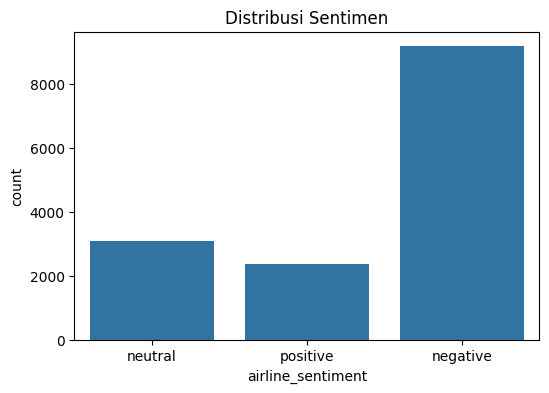

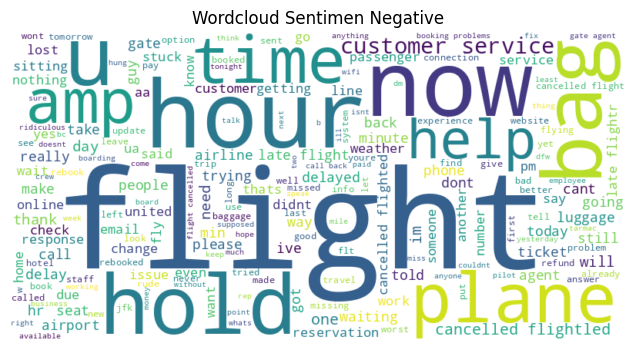

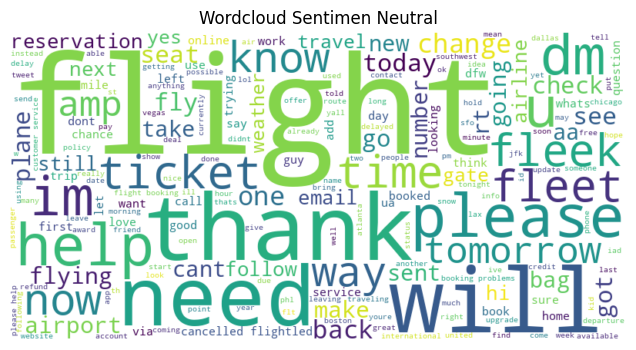

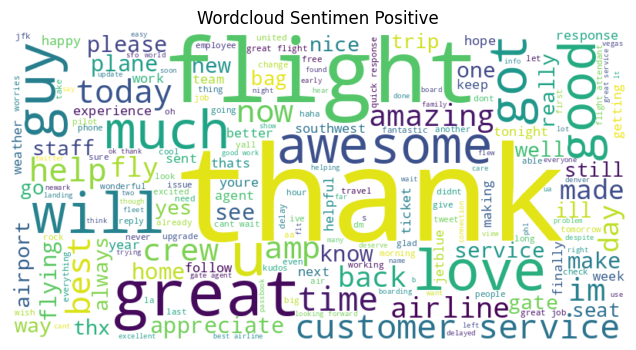

Classification Report:

              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1889
     neutral       0.74      0.16      0.26       580
    positive       0.91      0.23      0.37       459

    accuracy                           0.71      2928
   macro avg       0.78      0.46      0.48      2928
weighted avg       0.74      0.71      0.64      2928



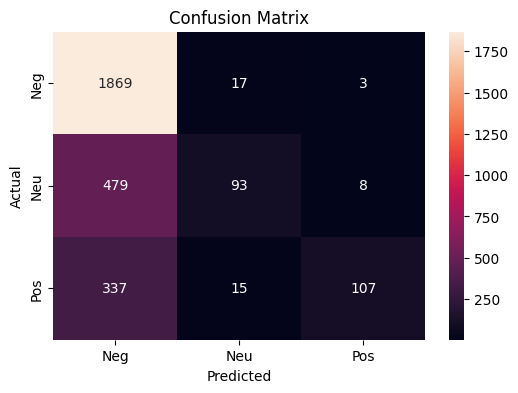

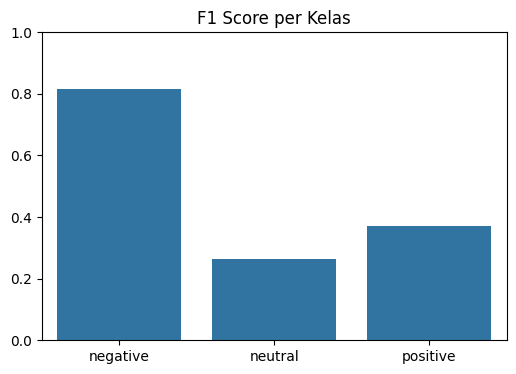

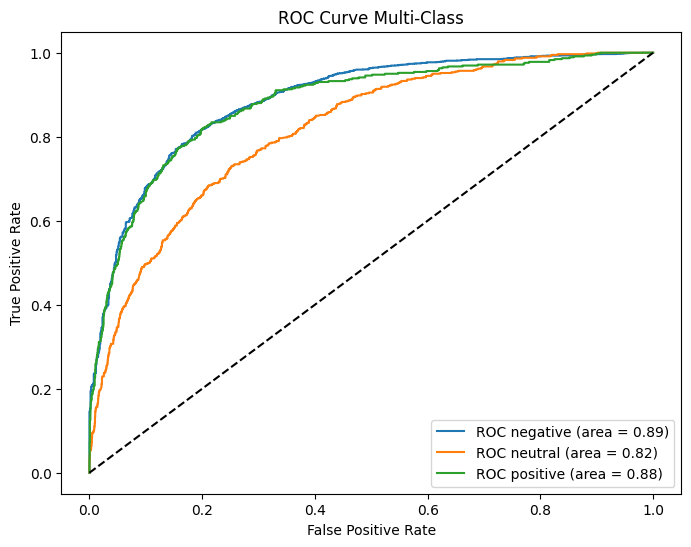

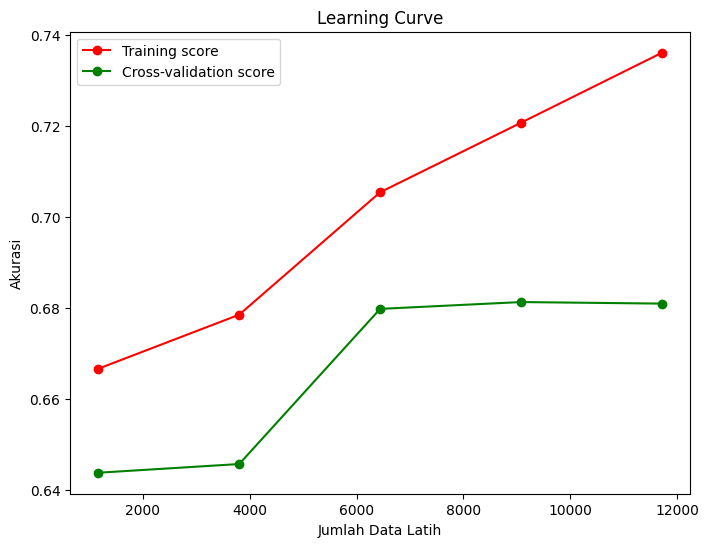

In [ ]:
from google.colab import files
uploaded = files.upload()

# 1. Import library
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 2. Load dataset (ganti path sesuai lokasi file)
df = pd.read_csv('Tweets.csv')

# 3. Lihat data awal
print(df[['text', 'airline_sentiment']].head())
print("Jumlah total data:", len(df))


# 4. Preprocessing teks
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # hapus URL
    text = re.sub(r'@\w+', '', text)  # hapus mention
    text = re.sub(r'#\w+', '', text)  # hapus hashtag
    text = re.sub(f"[{string.punctuation}]", '', text)  # hapus tanda baca
    text = re.sub(r'\d+', '', text)  # hapus angka
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)

# 5. Visualisasi distribusi label
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.show()

# 6. Wordcloud per kelas sentimen
for sentiment in ['negative', 'neutral', 'positive']:
    text = " ".join(df[df['airline_sentiment'] == sentiment]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud Sentimen {sentiment.capitalize()}')
    plt.show()

# 7. Label dan fitur
X = df['clean_text']
y = df['airline_sentiment']

# 8. TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = tfidf.fit_transform(X)

# 9. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42)

# 10. Training model Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# 11. Prediksi dan evaluasi
y_pred = nb.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 12. Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13. F1-score per kelas dengan barplot
f1 = f1_score(y_test, y_pred, average=None, labels=['negative', 'neutral', 'positive'])
classes = ['negative', 'neutral', 'positive']

plt.figure(figsize=(6,4))
sns.barplot(x=classes, y=f1)
plt.title('F1 Score per Kelas')
plt.ylim(0,1)
plt.show()

# 14. ROC Curve multi-class
# Binarize label
y_test_bin = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
y_train_bin = label_binarize(y_train, classes=['negative', 'neutral', 'positive'])

# OneVsRestClassifier untuk Naive Bayes agar dapat probabilitas
ovr_nb = OneVsRestClassifier(MultinomialNB())
ovr_nb.fit(X_train, y_train_bin)

y_score = ovr_nb.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, class_name in enumerate(['negative', 'neutral', 'positive']):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC {class_name} (area = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multi-Class')
plt.legend(loc='lower right')
plt.show()

# 15. Learning curve
train_sizes, train_scores, test_scores = learning_curve(nb, X_tfidf, y, cv=5,
                                                       train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy')

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Cross-validation score')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Akurasi')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()